In [1]:
import pandas as pd
import numpy as np  


In [2]:
df=pd.read_csv(r"D:\Final_Project\SENTIMENT_ANALYSIS\sentiment_excel.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rating           1200 non-null   int64 
 1   review_feedback  1200 non-null   object
 2   sentiment        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.2+ KB


In [4]:
df.head()

,rating,review_feedback,sentiment
0,3,The service was okay,Neutral
1,4,Very satisfied with the care and quick recovery,Positive
2,4,Staff were supportive and the hospital was clean,Positive
3,3,Neither good nor bad experience,Neutral
4,5,Treatment was effective and well managed,Positive


In [5]:
df['rating'].value_counts()

rating
3    418
2    211
5    193
1    191
4    187
Name: count, dtype: int64

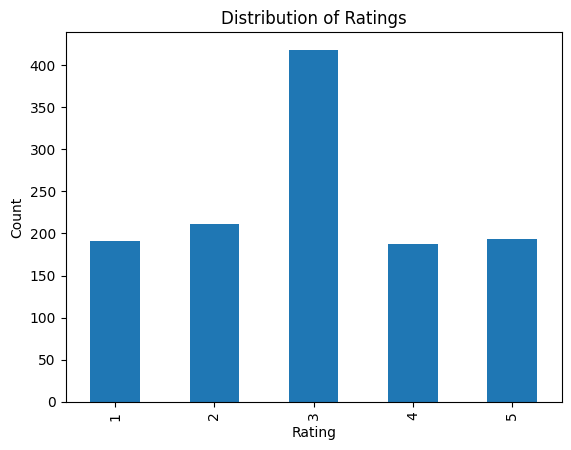

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [7]:
df['sentiment'].value_counts()

sentiment
Neutral     418
Negative    402
Positive    380
Name: count, dtype: int64

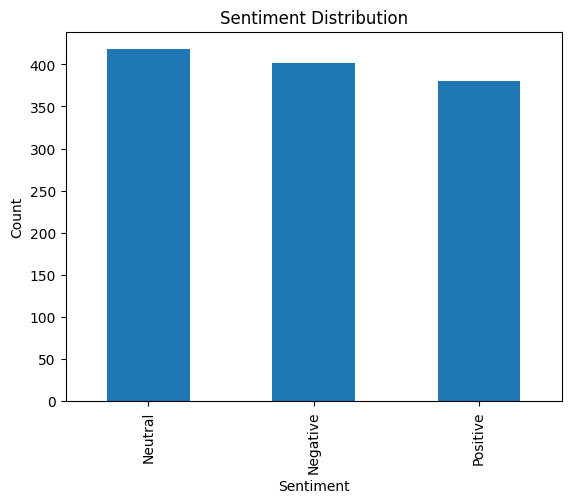

In [8]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

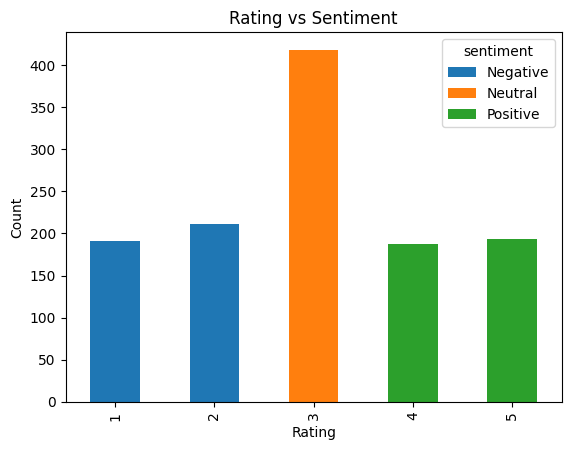

In [9]:
#Sentiment vs Rating Relationship
pd.crosstab(df["rating"], df["sentiment"])
pd.crosstab(df["rating"], df["sentiment"]).plot(kind="bar", stacked=True)
plt.title("Rating vs Sentiment")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [10]:
#Review Length Analysis (Text EDA)
df["review_length"] = df["review_feedback"].apply(lambda x: len(x.split()))
df["review_length"].describe()


count    1200.000000
mean        5.849167
std         1.603712
min         4.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: review_length, dtype: float64

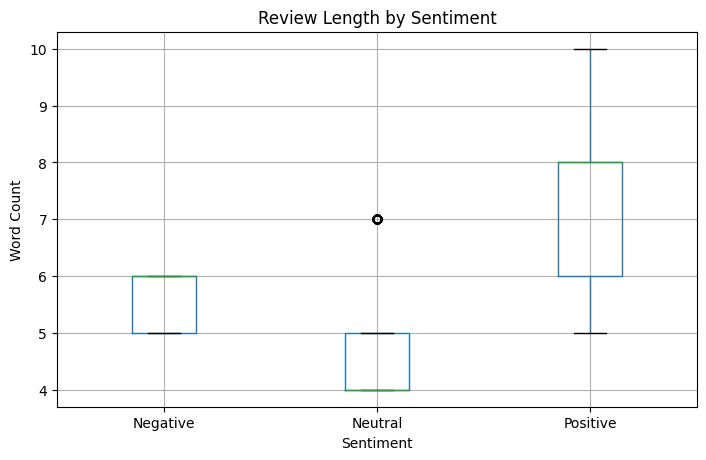

In [11]:
df.boxplot(column="review_length", by="sentiment", figsize=(8,5))
plt.title("Review Length by Sentiment")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()


🔍 Insights

Negative reviews often longer (complaints)

Positive reviews usually shorter

Neutral reviews show wide variance

In [12]:
from collections import Counter

for s in df['sentiment'].unique():
    words = " ".join(df[df['sentiment']==s]['review_feedback'].astype(str)).lower().split()
    print(s, Counter(words).most_common(10))

Neutral [('was', 263), ('hospital', 101), ('stay', 101), ('normal', 101), ('treatment', 85), ('fine', 85), ('but', 85), ('could', 85), ('be', 85), ('improved', 85)]
Positive [('and', 380), ('the', 290), ('was', 225), ('were', 158), ('excellent', 147), ('very', 132), ('treatment', 129), ('staff', 96), ('supportive', 96), ('hospital', 96)]
Negative [('and', 246), ('the', 225), ('staff', 162), ('with', 156), ('bad', 93), ('experience', 93), ('careless', 93), ('long', 84), ('waiting', 84), ('time', 84)]


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=10)
X = vectorizer.fit_transform(df["review_feedback"])

pd.DataFrame({
    "word": vectorizer.get_feature_names_out(),
    "count": X.toarray().sum(axis=0)
}).sort_values("count", ascending=False)


,word,count
9,treatment,298
3,hospital,280
7,staff,258
2,experience,248
6,service,235
0,bad,164
5,satisfied,153
1,excellent,147
4,normal,101
8,stay,101


In [14]:
label_map = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

df["label"] = df["sentiment"].map(label_map)
df.head()


,rating,review_feedback,sentiment,review_length,label
0,3,The service was okay,Neutral,4,1
1,4,Very satisfied with the care and quick recovery,Positive,8,2
2,4,Staff were supportive and the hospital was clean,Positive,8,2
3,3,Neither good nor bad experience,Neutral,5,1
4,5,Treatment was effective and well managed,Positive,6,2


In [15]:
df['label'].value_counts()

label
1    418
0    402
2    380
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)


In [17]:
!pip install transformers datasets torch scikit-learn pandas joblib
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[["review_feedback", "label"]])
val_ds   = Dataset.from_pandas(val_df[["review_feedback", "label"]])


c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tokenization (BERT)

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["review_feedback"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 240/240 [00:00<00:00, 6865.45 examples/s]


# Model initialization

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics (accuracy)

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="weighted"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [21]:
!pip install -U transformers datasets

In [22]:
import transformers
print(transformers.__version__)

4.57.3


In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./sentiment_model",
    eval_strategy="epoch",     # ✅ correct for v4.57.3
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    report_to="none"           # avoids wandb issues
)


In [24]:
!pip install --upgrade accelerate

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


C:\Users\ashwi\AppData\Local\Temp\ipykernel_10496\2110798571.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.512800,0.033634,1.000000,1.000000,1.000000,1.000000
2,0.030700,0.009614,1.000000,1.000000,1.000000,1.000000
3,0.012300,0.006449,1.000000,1.000000,1.000000,1.000000
4,0.008800,0.005717,1.000000,1.000000,1.000000,1.000000


c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:255: VisibleDeprecationWarning: Creating an ndarray from r

TrainOutput(global_step=240, training_loss=0.11889827164510886, metrics={'train_runtime': 694.4886, 'train_samples_per_second': 5.529, 'train_steps_per_second': 0.346, 'total_flos': 127170970583040.0, 'train_loss': 0.11889827164510886, 'epoch': 4.0})

In [26]:
results = trainer.evaluate()
print(results)


c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:255: VisibleDeprecationWarning: Creating an ndarray from r

{'eval_loss': 0.033634353429079056, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 9.365, 'eval_samples_per_second': 25.627, 'eval_steps_per_second': 1.602, 'epoch': 4.0}


In [27]:
trainer.save_model("sentiment_transformer")
tokenizer.save_pretrained("sentiment_transformer")

('sentiment_transformer\\tokenizer_config.json',
 'sentiment_transformer\\special_tokens_map.json',
 'sentiment_transformer\\vocab.txt',
 'sentiment_transformer\\added_tokens.json',
 'sentiment_transformer\\tokenizer.json')